# OCR CNN Model Code

In this Google Colab Notebook, I dealt with the data and trained a Convolutional Neural Network that can recognize digits and alphabet with very high accuracy using TF and Keras that will distinguish handwritten letters and numbers. This model will be saved and used for the OCR after some other processing.

## Setup and Loading Data
Code reference: https://www.kaggle.com/medali1992/resnet50d-train-mnist-a-z

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Imports
from tensorflow.keras.utils import to_categorical, plot_model, normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

### Digits Data

In [ ]:
# Load digits mnist data
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
# Stacking data and labels for combining with a-z
digits_data = np.vstack([train_data, test_data])
digits_labels = np.hstack([train_labels, test_labels])

### Letters Data

In [ ]:
# Load letters data
az_data = []
az_labels = []
# Read CSV by manually splitting by commas (I think manual is easier for images)
for row in open("/content/drive/MyDrive/A_Z Handwritten Data.csv"):
    row = row.split(",")
    # Label
    label = int(row[0])
    az_labels.append(label)
    # Data (image)
    image = np.array([int(x) for x in row[1:]], dtype="uint8")
    image = image.reshape((28, 28))
    az_data.append(image)
print(len(az_data))

372451


### Merging Datasets

In [ ]:
# Converting to float and int numpy arrays (to match digits data)
az_data = np.array(az_data, dtype='float32')
az_labels = np.array(az_labels, dtype="int")
# Incrementing alphabet labels since digits uses 0 - 9
az_labels += 10

# Combining the datasets
data = np.vstack([az_data, digits_data])
labels = np.hstack([az_labels, digits_labels])

# Add a dimension to the image for CNN and normalize pixels (0 to 1)
data = np.expand_dims(data, axis=-1)
data = normalize(data, axis=1)

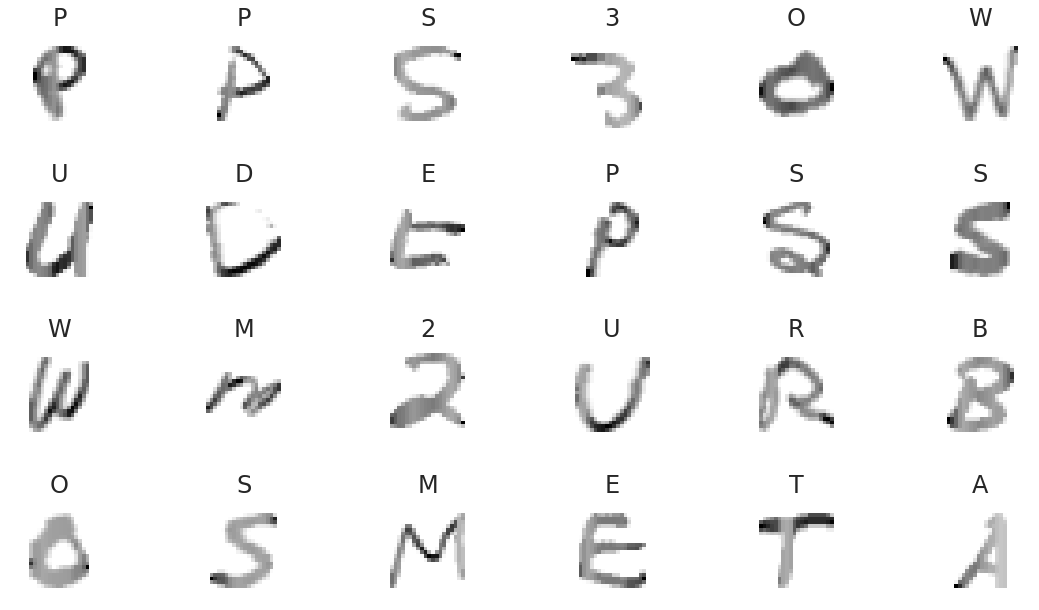

In [ ]:
# Key for what each label actually corresponds to
label_key = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Shows some examples with the correct answer with the image of the number
sns.set(font_scale=2)  # font size
index = np.random.choice(np.arange(len(data)), 24, replace=False)  # random 24
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 9))  # 4 x 6 plot
for item in zip(axes.ravel(), data[index], labels[index]):  # plot all things
    axes, image, target = item
    axes.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(label_key[target.item()])
plt.tight_layout()
plt.show()

# Making labels into arrays for training
labels = to_categorical(labels)

## Convolutional Neural Network

### Structure

In [ ]:
# Train test split for data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=11)

# Sequentially build CNN network
cnn = Sequential()
# Conv2D and Pooling Layers
cnn.add(Conv2D(filters=64, # 64 filters
               kernel_size=(3, 3),  # normal 3x3 for kernel size,
               activation='relu', input_shape=(28, 28, 1)))  # relu and shape
cnn.add(MaxPooling2D(pool_size=(2, 2)))  # max pooling layer, 2x2 pool size
cnn.add(Conv2D(filters=128, # 128 filters
               kernel_size=(3, 3), activation='relu'))  # others are same as b4
cnn.add(MaxPooling2D(pool_size=(2, 2)))  # max pooling layer again
# Flatten and Dense Layers
cnn.add(Flatten())  # flatten picture so it is 1 dimensional for dense layers
cnn.add(Dense(units=256, activation='relu'))  # dense, 256 nodes, relu
cnn.add(Dense(units=128, activation='relu'))  # dense, 128 nodes, relu
# Output layer
cnn.add(Dense(units=36, activation='softmax'))  # dense, 10 nodes, softmax
print(cnn.summary())  # print summary of model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 256)               8

### Training and Saving

In [ ]:
cnn.compile(optimizer='adam',  # using adam to tune weights and optimize
            loss='categorical_crossentropy',  
            metrics=['accuracy']) 

# Fitting and checking model. Batch size of 64 before checking, 2 epochs/rounds
# validation split keeps 10% of data per epoch for checking accuracy and loss
cnn.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.1)

# saving model
cnn.save("ocrcnn.h5")

Epoch 1/2
5600/5600 [==============================] - 735s 131ms/step - loss: 0.0598 - accuracy: 0.9820 - val_loss: 0.0620 - val_accuracy: 0.9817
Epoch 2/2
5600/5600 [==============================] - 733s 131ms/step - loss: 0.0423 - accuracy: 0.9869 - val_loss: 0.0590 - val_accuracy: 0.9840


### Testing Model

In [ ]:
# Checking loss and accuracy on test data
loss, accuracy = cnn.evaluate(X_test, y_test)
print(loss)
print(accuracy)

1383/1383 [==============================] - 29s 21ms/step - loss: 0.0582 - accuracy: 0.9835
0.05821910873055458
0.9834561347961426


In [ ]:
# Using predict to test on testing data
predictions = cnn.predict(X_test)
print(y_test[0])

# Prints every prediction and probability
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
0: 0.0000000000%
1: 0.0000000160%
2: 0.0000000019%
3: 0.0000000004%
4: 0.0000000000%
5: 0.0000000069%
6: 0.0000000000%
7: 0.0000072929%
8: 0.0000000001%
9: 0.0000000000%
10: 0.0000000000%
11: 0.0000000001%
12: 0.0000033914%
13: 0.0000000030%
14: 0.0000000007%
15: 0.0000000273%
16: 0.0000008332%
17: 0.0000000002%
18: 0.0000000663%
19: 0.0013039320%
20: 0.0000000019%
21: 0.0000000220%
22: 0.0000004599%
23: 0.0000003131%
24: 0.0000001962%
25: 0.0000020635%
26: 0.0000000000%
27: 0.0000000000%
28: 0.0000048297%
29: 99.9982118607%
30: 0.0000005083%
31: 0.0000000000%
32: 0.0000000030%
33: 0.0000000428%
34: 0.0004665391%
35: 0.0000016673%


In [ ]:
# Reshaping images (removing one dimension)
images = X_test.reshape((44246, 28, 28))
incorrect_predictions = []

# Looking at predictions and actual answers
for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)  # predicted and expected
    # Keep track of incorrect
    if predicted != expected:
        incorrect_predictions.append((i, images[i], predicted, expected))
print("number of incorrect: ", len(incorrect_predictions))

number of incorrect:  732


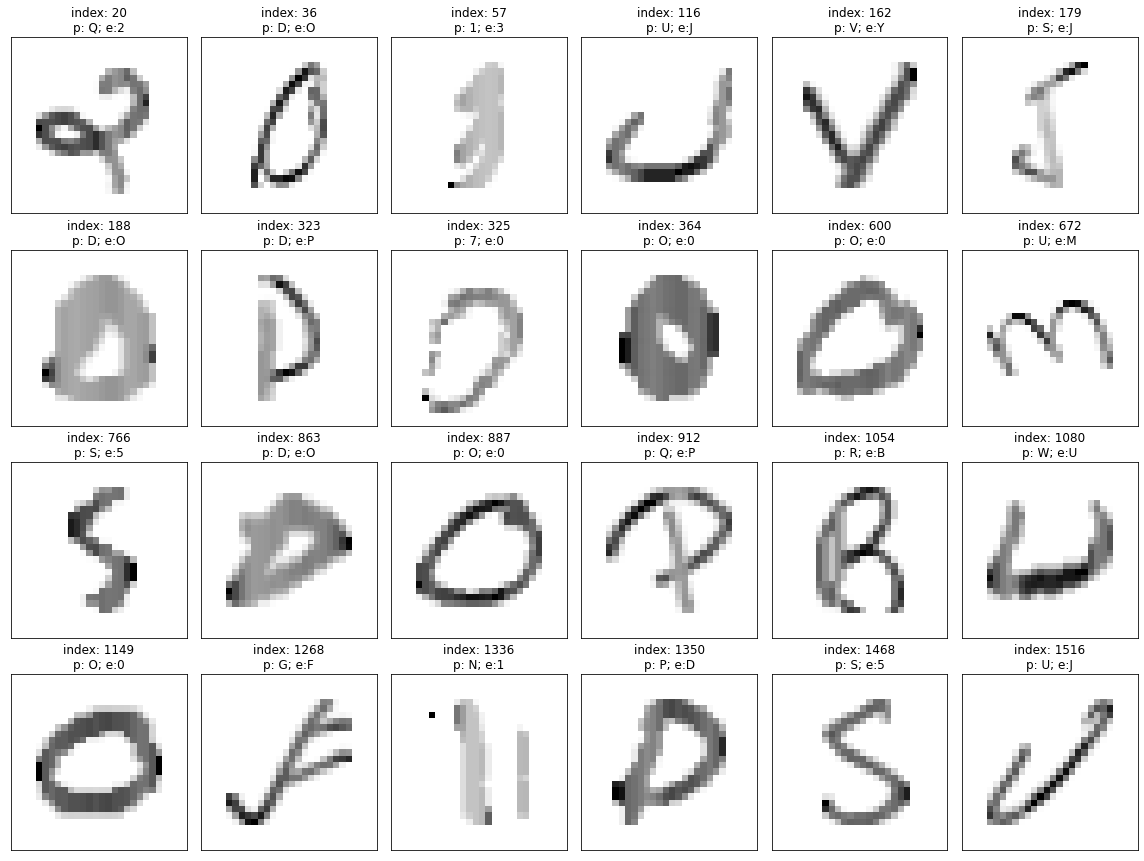

In [ ]:
# Pulls up a 4 x 6 subplot to look at predicted and expected for wrong stuff
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 12))
for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'index: {index}\np: {label_key[predicted]}; e:{label_key[expected]}')
plt.tight_layout()
plt.show()